In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive')
os.getcwd()

'/content/drive/My Drive'

In [3]:
if not os.path.exists('data'):
    os.mkdir('data')

os.chdir('data')
os.getcwd()

'/content/drive/My Drive/data'

In [5]:
!wget https://download.pytorch.org/tutorial/data.zip

--2020-10-06 09:37:43--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.106, 99.86.38.96, 99.86.38.37, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.2’

data.zip.2          100%[===================>]   2.75M  5.33MB/s    in 0.5s    

2020-10-06 09:37:44 (5.33 MB/s) - ‘data.zip.2’ saved [2882130/2882130]



In [6]:
!unzip data.zip

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Classifying Names with a Character-Level RNN

**Author**: Sean Robertson <https://github.com/spro/practical-pytorch>_

We will be building and training a basic character-level RNN to classify words. A character-level RNN reads words as a series of characters - outputting a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


In [4]:
from __future__ import unicode_literals, absolute_import, division, print_function
from io import open
import glob 
import os
import unicodedata 
import string

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [5]:
def find_files(path): return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c)!='Mn'
        and c in all_letters
    )    

category_lines = {}
all_categories = []
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

In [6]:
for key in category_lines.keys():
    print(key, " : ", ", ".join(category_lines[key][:5]))

Greek  :  Adamidis, Adamou, Agelakos, Akrivopoulos, Alexandropoulos
Spanish  :  Abana, Abano, Abarca, Abaroa, Abascal
Korean  :  Ahn, Baik, Bang, Byon, Cha
Dutch  :  Aalsburg, Aalst, Aarle, Achteren, Achthoven
Russian  :  Ababko, Abaev, Abagyan, Abaidulin, Abaidullin
Scottish  :  Smith, Brown, Wilson, Campbell, Stewart
Arabic  :  Khoury, Nahas, Daher, Gerges, Nazari
German  :  Abbing, Abel, Abeln, Abt, Achilles
Polish  :  Adamczak, Adamczyk, Andrysiak, Auttenberg, Bartosz
Italian  :  Abandonato, Abatangelo, Abatantuono, Abate, Abategiovanni
English  :  Abbas, Abbey, Abbott, Abdi, Abel
French  :  Abel, Abraham, Adam, Albert, Allard
Portuguese  :  Abreu, Albuquerque, Almeida, Alves, Araujo
Czech  :  Abl, Adsit, Ajdrna, Alt, Antonowitsch
Irish  :  Adam, Ahearn, Aodh, Aodha, Aonghuis
Japanese  :  Abe, Abukara, Adachi, Aida, Aihara
Chinese  :  Ang, AuYong, Bai, Ban, Bao
Vietnamese  :  Nguyen, Tron, Le, Pham, Huynh


In [7]:
def letter_to_index(letter):
    return all_letters.find(letter)

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

In [8]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size 
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [9]:
n_hidden = 128
n_categories = len(category_lines.keys())
rnn = RNN(n_letters, n_hidden, n_categories)

In [10]:
input = Variable(line_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8907, -2.9740, -2.7962, -2.8719, -2.8576, -2.7710, -2.8688, -2.8926,
         -2.8772, -2.9687, -2.8322, -2.9443, -2.9295, -2.8638, -2.9091, -2.9412,
         -2.9062, -2.9592]], grad_fn=<LogSoftmaxBackward>)


In [11]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Scottish', tensor(5))


In [12]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Scottish / line = Gray
category = Dutch / line = Kan
category = German / line = Lorenzen
category = English / line = Luker
category = Russian / line = Deryabin
category = Korean / line = Chung
category = Polish / line = Gwozdek
category = Arabic / line = Kattan
category = Russian / line = Jamsuev
category = Arabic / line = Shamon


In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
rnn = RNN(n_letters, n_hidden, n_categories).to(device)
criterion = nn.NLLLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    optimizer.zero_grad()

    hidden = rnn.init_hidden()
    hidden = hidden.to(device)

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [14]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 500
current_loss = 0
all_losses = []

In [15]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

start = time.time()

for epoch in range(1, n_epochs+1):
    category, line, category_tensor, line_tensor = random_training_pair()
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else 'X (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))
    
    if epoch % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0

5000 5% (0m 12s) 1.8114 Inouye / Japanese ✓
10000 10% (0m 24s) 0.1691 Vassilopulos / Greek ✓
15000 15% (0m 36s) 3.2804 Aalst / Arabic X (Dutch)
20000 20% (0m 48s) 1.2780 Chevalier / French ✓
25000 25% (1m 0s) 0.5365 Bishara / Arabic ✓
30000 30% (1m 12s) 0.0047 Czajkowski / Polish ✓
35000 35% (1m 24s) 3.3916 Mihelson / Scottish X (Russian)
40000 40% (1m 37s) 0.4224 Sepelev / Russian ✓
45000 45% (1m 49s) 0.3703 Basara / Arabic ✓
50000 50% (2m 1s) 2.1040 Rivero / Italian X (Spanish)
55000 55% (2m 13s) 0.1349 Troitsky / Russian ✓
60000 60% (2m 25s) 1.2707 Nikolaou / Japanese X (Greek)
65000 65% (2m 37s) 0.8070 Meisner / German ✓
70000 70% (2m 49s) 1.3564 Wendell / German ✓
75000 75% (3m 1s) 2.3902 Jobst / German X (Czech)
80000 80% (3m 13s) 0.2300 Fan / Chinese ✓
85000 85% (3m 25s) 2.1843 Haik / Korean X (Arabic)
90000 90% (3m 37s) 0.2537 Kaminski / Polish ✓
95000 95% (3m 49s) 1.2797 Davidson / French X (English)
100000 100% (4m 2s) 0.3936 Ryskamp / Dutch ✓


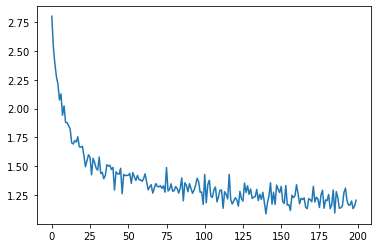

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [20]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    hidden = hidden.to(device)
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

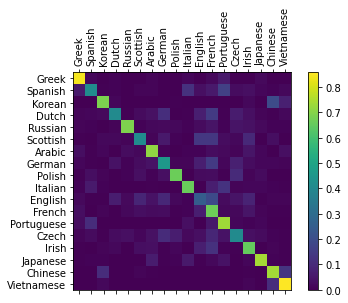

In [22]:
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = plt.subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [25]:
def predict(input_line, n_predictions=5):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line).to(device))
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [42]:
predict('john')
predict('jane')


> john
(-0.76) Dutch
(-1.42) Irish
(-2.71) English
(-2.91) Scottish
(-2.99) German

> jane
(-0.84) Dutch
(-1.99) Scottish
(-2.28) Japanese
(-2.32) English
(-2.52) French
